In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-10-01 00:58:47.489659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 00:58:48.298852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [33]:
@tf.function
def ic_func(model, x, t, u, u_t):
    u_pred = model([x, t], training=True)
    u_t_pred = tf.gradients(u_pred, t)[0]
    ic_loss_f = u_pred - u
    ic_loss_df = u_t_pred - u_t
    return ic_loss_f, ic_loss_df

@tf.function
def bc_func(model, x, t, u):
    u_pred = model([x, t], training=True)
    bc_loss_f = u_pred - u
    return bc_loss_f

@tf.function
def pde_func(model, x, t):
    u = model([x, t], training=True)
    u_t  = tf.gradients(u, t)[0]
    u_tt = tf.gradients(u_t, t)[0]
    u_x  = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    return u_tt - u_xx

@tf.function
def loss_func(model, x_i, t_i, u_i, u_t_i, x_b, t_b, u_b, x_f, t_f):
        
    ic_f, ic_df = ic_func(model, x_i, t_i, u_i, u_t_i)
    bc_f = bc_func(model, x_b, t_b, u_b)
    domain = pde_func(model, x_f, t_f)
                
    return tf.reduce_mean(tf.square(ic_f)) + \
           tf.reduce_mean(tf.square(ic_df)) + \
           tf.reduce_mean(tf.square(bc_f)) + \
           tf.reduce_mean(tf.square(domain))

@tf.function
def loss_and_gradients(model, x_i, t_i, u_i, u_t_i, x_b, t_b, u_b, x_f, t_f):

    with tf.GradientTape() as tape:
        model_loss=loss_func(model, x_i, t_i, u_i, u_t_i, x_b, t_b, u_b, x_f, t_f)
    model_gradients = tape.gradient(model_loss, model.trainable_weights)
    
    return model_loss, model_gradients

In [34]:
def train(model, train_data):
    
    optimizer = tf.keras.optimizers.Adam()
    nIter = 1000
        
    x_i = train_data['x_i']
    t_i = train_data['t_i']
    x_b = train_data['x_b']
    t_b = train_data['t_b']
    u_i = train_data['u_i']
    u_t_i = train_data['u_t_i']
    u_b = train_data['u_b']
    x_f = train_data['x_f']
    t_f = train_data['t_f']

    for it in range(nIter):
                
        model_loss, model_gradients = loss_and_gradients(model, x_i, t_i, u_i, u_t_i, x_b, t_b, u_b, x_f, t_f)
        optimizer.apply_gradients(zip(model_gradients, model.trainable_weights))
        
        if (it % 1 == 0):
            print(f'{model_loss} {it}')

In [35]:
input1  = tf.keras.layers.Input(shape=(1,))
input2  = tf.keras.layers.Input(shape=(1,))
merged  = tf.keras.layers.Concatenate(axis=1)([input1, input2])
layer1  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(merged)
layer2  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(layer1)
layer3  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(layer2)
layer4  = tf.keras.layers.Dense(units = 64, activation=tf.tanh)(layer3)
outputs = tf.keras.layers.Dense(units = 1, activation=None)(layer4)
model   = tf.keras.Model(inputs=[input1, input2], outputs=outputs)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 2)                    0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 64)                   192       ['concatenate_1[0][0]'] 

In [37]:
model.save_weights('model.h5')

In [38]:
xcoords = np.linspace(0.0, 100.0, 200)[:,None] #Slicing to make a *column* vector
tcoords = np.linspace(0.0, 100.0, 200)[:,None]

In [39]:
X, T = np.meshgrid(xcoords, tcoords)

In [40]:
x = X.flatten()[:,None]
t = T.flatten()[:,None]

In [41]:
x_i = xcoords.copy()
t_i = tcoords.copy()

In [42]:
t_i[:,0] = 0.0

In [43]:
mu = 20.0
u_i = np.exp(-0.1*(x_i-mu)**2)
u_t_i = ((0.2*(x_i-mu))*np.exp(-0.1*(x_i-mu)**2))

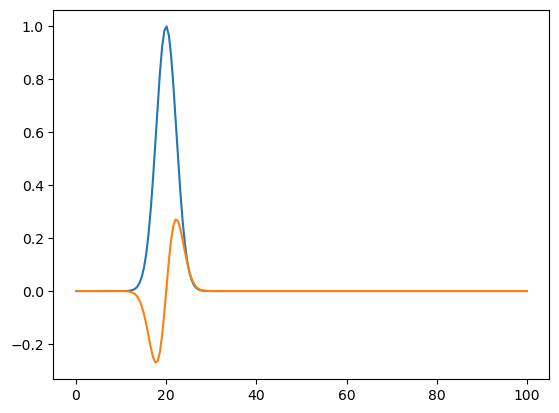

In [44]:
plt.plot(x_i, u_i)
plt.plot(x_i, u_t_i)

In [45]:
x_b = np.array([0.0, 100.0])[:,None]
t_b = np.array([0.0, 0.0])[:,None]

In [46]:
u_b = np.array([0.0, 0.0])[:,None]

In [47]:
x.shape

(40000, 1)

In [48]:
model([x_b, t_b])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.19818932]], dtype=float32)>

In [49]:
idx = np.random.choice(x.shape[0], 4000, replace=False)
x_f = x[idx,:]
t_f = t[idx,:]

In [50]:
model([x_f, t_f])

<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[ 0.18597446],
       [ 0.2413216 ],
       [ 0.17373075],
       ...,
       [ 0.21156655],
       [-0.06290841],
       [ 0.44899535]], dtype=float32)>

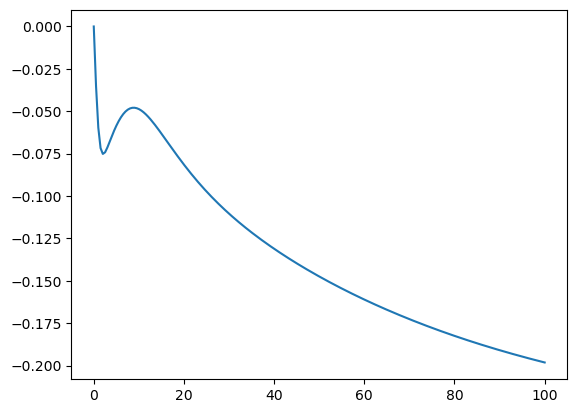

In [51]:
plt.plot(x[:200,:],model([x[:200,:],t[:200,:]]))

In [52]:
training_data = {'x_i': x_i.astype('float32'),
                 't_i': t_i.astype('float32'),
                 'x_b': x_b.astype('float32'),
                 't_b': t_b.astype('float32'),
                 'u_i': u_i.astype('float32'),
                 'u_t_i': u_t_i.astype('float32'),
                 'u_b': u_b.astype('float32'),
                 'x_f': x_f.astype('float32'),
                 't_f': t_f.astype('float32')}

In [53]:
model.load_weights('model.h5')

In [56]:
train(model, training_data)

4.518835339695215e-05 0
0.0005705651128664613 1
0.12079377472400665 2
0.017696278169751167 3
0.08047723770141602 4
0.05047259107232094 5
0.007375073619186878 6
0.027833204716444016 7
0.05332754924893379 8
0.03515719622373581 9
0.0073617491871118546 10
0.005510175600647926 11
0.02021954208612442 12
0.023333456367254257 13
0.012227263301610947 14
0.00476462347432971 15
0.009597403928637505 16
0.016145741567015648 17
0.01299676951020956 18
0.0040001943707466125 19
0.0003763534186873585 20
0.005013210233300924 21
0.009938984178006649 22
0.008467121049761772 23
0.0034648252185434103 24
0.0015341315884143114 25
0.003728920593857765 26
0.005314278416335583 27
0.0034650955349206924 28
0.0009345999569632113 29
0.0012258165515959263 30
0.003427831456065178 31
0.0039873188361525536 32
0.0020349121186882257 33
0.00023247496574185789 34
0.0006252675666473806 35
0.0019792672246694565 36
0.0020851106382906437 37
0.0010122820967808366 38
0.0004953531897626817 39
0.0010484115919098258 40
0.001426685485

2.2415828425437212e-05 317
2.2376103515853174e-05 318
2.233634950243868e-05 319
2.2296651877695695e-05 320
2.225700518465601e-05 321
2.221745853603352e-05 322
2.217793371528387e-05 323
2.2138277927297167e-05 324
2.2098836780060083e-05 325
2.2059444745536894e-05 326
2.2020227333996445e-05 327
2.1980886231176555e-05 328
2.1941279555903748e-05 329
2.190219129261095e-05 330
2.1862939320271835e-05 331
2.1823732822667807e-05 332
2.1784791897516698e-05 333
2.1745527192251757e-05 334
2.170660263800528e-05 335
2.1667583496309817e-05 336
2.1628524336847477e-05 337
2.1589696189039387e-05 338
2.155068432330154e-05 339
2.1511981685762294e-05 340
2.1473149899975397e-05 341
2.1434294467326254e-05 342
2.1395604562712833e-05 343
2.1356931029004045e-05 344
2.1318204744602554e-05 345
2.1279480279190466e-05 346
2.1240881324047223e-05 347
2.120238059433177e-05 348
2.1163868950679898e-05 349
2.112527727149427e-05 350
2.108673106704373e-05 351
2.1048228518338874e-05 352
2.100981328112539e-05 353
2.0971401681

1.3008897440158762e-05 625
1.2985276953259017e-05 626
1.2961949323653243e-05 627
1.293870354857063e-05 628
1.2915741535834968e-05 629
1.2892967788502574e-05 630
1.287034774577478e-05 631
1.2847901416535024e-05 632
1.2825788871850818e-05 633
1.2803519894077908e-05 634
1.2781722944055218e-05 635
1.275998874916695e-05 636
1.2738466466544196e-05 637
1.2717202480416745e-05 638
1.269590029551182e-05 639
1.2675054676947184e-05 640
1.2654289093916304e-05 641
1.2633683581952937e-05 642
1.2613320905074943e-05 643
1.2593252904480323e-05 644
1.2573272215377074e-05 645
1.255354072782211e-05 646
1.253387745236978e-05 647
1.251441972272005e-05 648
1.2495091141317971e-05 649
1.2476093615987338e-05 650
1.2457140655897092e-05 651
1.243825681740418e-05 652
1.241950667463243e-05 653
1.240113670064602e-05 654
1.2382589375192765e-05 655
1.236420121131232e-05 656
1.2346156836429145e-05 657
1.2328140655881725e-05 658
1.2310159945627674e-05 659
1.2292384781176224e-05 660
1.2274578693904914e-05 661
1.2257034541

9.004487765196245e-06 935
8.996108590508811e-06 936
8.98783309821738e-06 937
8.979535778053105e-06 938
8.971274837676901e-06 939
8.962965694081504e-06 940
8.95466837391723e-06 941
8.946562957135029e-06 942
8.938269274949562e-06 943
8.930066542234272e-06 944
8.921809239836875e-06 945
8.913792044040747e-06 946
8.905532922653947e-06 947
8.897384759620763e-06 948
8.889327546057757e-06 949
8.881173926056363e-06 950
8.873117621988058e-06 951
8.865138624969404e-06 952
8.857023203745484e-06 953
8.848959623719566e-06 954
8.840765076456591e-06 955
8.832817002257798e-06 956
8.82488257047953e-06 957
8.816814442980103e-06 958
8.808865459286608e-06 959
8.801009244052693e-06 960
8.792901098786388e-06 961
8.784975761955138e-06 962
8.77708680491196e-06 963
8.769155101617798e-06 964
8.761277968005743e-06 965
8.753338988753967e-06 966
8.745524610276334e-06 967
8.737632015254349e-06 968
8.729824003239628e-06 969
8.722079655854031e-06 970
8.714203431736678e-06 971
8.706471817276906e-06 972
8.69856376084499

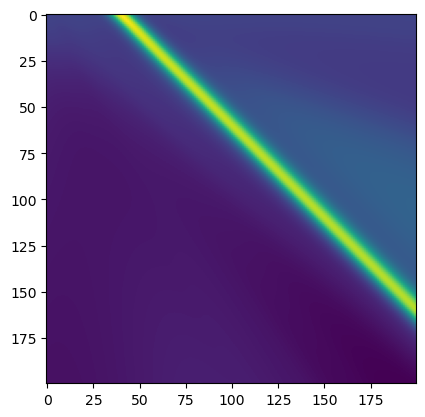

In [57]:
plt.imshow(model([x,t]).numpy().reshape((200,200)))

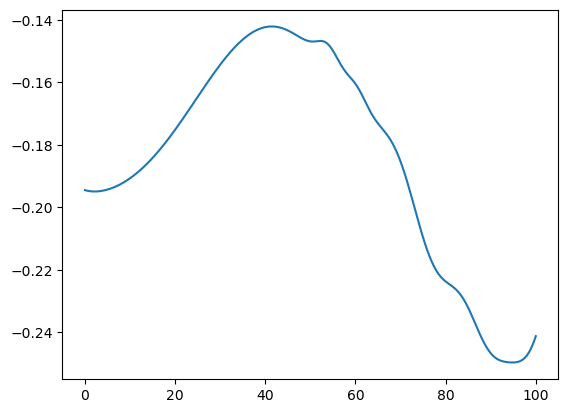

In [58]:
plt.plot(x[39800:,:],model([x[39800:,:],t[39800:,:]]))